# Wind Power Forecasting

## Context
Here's data of a certain windmill. The aim was to predict the wind power that could be generated from the windmill for the next 15 days. A long term wind forecasting technique is thus required.

## Content
It contains various weather, turbine and rotor features. Data has been recorded from January 2018 till March 2020. Readings have been recorded at a 10-minute interval.

### Interesting Observation
A hybrid ARIMA-ANN model has been tested and given good results for modelling a single variable. Check out the paper

https://www.sciencedirect.com/science/article/abs/pii/S0925231201007020

### Sources
https://www.kaggle.com/theforcecoder/wind-power-forecasting 

https://www.hindawi.com/journals/mpe/2010/684742/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

pd.set_option('display.max_columns', None)


In [2]:
# Unnamed column is actually DateTime.
df = pd.read_csv("Turbine_Data.csv", parse_dates=['Unnamed: 0'])

df.rename(columns={'Unnamed: 0':'DateTime', 'AmbientTemperatue':'AmbientTemperature'}, inplace=True)
df.DateTime = pd.to_datetime(df.DateTime)
df = df.set_index('DateTime')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118224 entries, 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ActivePower                   94750 non-null   float64
 1   AmbientTemperature            93817 non-null   float64
 2   BearingShaftTemperature       62518 non-null   float64
 3   Blade1PitchAngle              41996 non-null   float64
 4   Blade2PitchAngle              41891 non-null   float64
 5   Blade3PitchAngle              41891 non-null   float64
 6   ControlBoxTemperature         62160 non-null   float64
 7   GearboxBearingTemperature     62540 non-null   float64
 8   GearboxOilTemperature         62438 non-null   float64
 9   GeneratorRPM                  62295 non-null   float64
 10  GeneratorWinding1Temperature  62427 non-null   float64
 11  GeneratorWinding2Temperature  62449 non-null   float64
 12

In [3]:
df.head(5)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [4]:
# Observation: The target variable is null on the whole first day.

df[df.ActivePower.isnull() == False].head(1)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,-9.96083,NaN,NaN,G01,8.0,2.279088


In [5]:
# Further inspection shows there is no data in any column on the first day (except WTG).

df[:144].isnull().sum()

ActivePower                     144
AmbientTemperature              144
BearingShaftTemperature         144
Blade1PitchAngle                144
Blade2PitchAngle                144
Blade3PitchAngle                144
ControlBoxTemperature           144
GearboxBearingTemperature       144
GearboxOilTemperature           144
GeneratorRPM                    144
GeneratorWinding1Temperature    144
GeneratorWinding2Temperature    144
HubTemperature                  144
MainBoxTemperature              144
NacellePosition                 144
ReactivePower                   144
RotorRPM                        144
TurbineStatus                   144
WTG                               0
WindDirection                   144
WindSpeed                       144
dtype: int64

In [6]:
# Let's remove the first 144 rows as they are useless.

df = df[144:]
df.head(1)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,-9.96083,NaN,NaN,G01,8.0,2.279088


In [7]:
def drop_constant_columns(df):
    '''Finds and removes any constant columns from the dataframe.
    Action is performed in place.'''
    drop_cols = list()
    for col in df.columns:
        if df[col].value_counts().size == 1:
            print(f"All entries in `{col}` column are `{df[col][0]}`.")
            drop_cols.append(col)
    if not drop_cols:
        print("No constant columns found.")
    else:
        print("Dropping columns...")
        df.drop(columns=drop_cols, inplace=True)
        
            
drop_constant_columns(df)

All entries in `ControlBoxTemperature` column are `nan`.
All entries in `WTG` column are `G01`.
Dropping columns...


In [8]:
# We have a lot of missing data.

df.isnull().sum() / df.shape[0]     # Given as percentages

ActivePower                     0.197578
AmbientTemperature              0.205479
BearingShaftTemperature         0.470545
Blade1PitchAngle                0.644343
Blade2PitchAngle                0.645232
Blade3PitchAngle                0.645232
GearboxBearingTemperature       0.470359
GearboxOilTemperature           0.471223
GeneratorRPM                    0.472434
GeneratorWinding1Temperature    0.471316
GeneratorWinding2Temperature    0.471130
HubTemperature                  0.471494
MainBoxTemperature              0.470639
NacellePosition                 0.387890
ReactivePower                   0.197595
RotorRPM                        0.473857
TurbineStatus                   0.467243
WindDirection                   0.387890
WindSpeed                       0.198891
dtype: float64

In [9]:
# Thought:
# We might be able to assume that good windmill engineering unsures that
# many of these features are optimized to ActivePower. 
#
# Under this assumption, we can probably ignore most, if not all, non-target features.

In [10]:
# Let's focus on our target, ActivePower.
# Observation: ActivePower can be negative, apparently.

power = df.ActivePower.copy()
power.describe()

count    94750.000000
mean       619.109805
std        611.275373
min        -38.524659
25%         79.642258
50%        402.654893
75%       1074.591780
max       1779.032433
Name: ActivePower, dtype: float64

In [11]:
# Too many negative values to be considered anomalies.
# Perhaps this is normal.

power[power < -1].describe()

count    15499.000000
mean        -6.169591
std          1.563767
min        -38.524659
25%         -6.738149
50%         -5.830176
75%         -5.317955
max         -1.014681
Name: ActivePower, dtype: float64

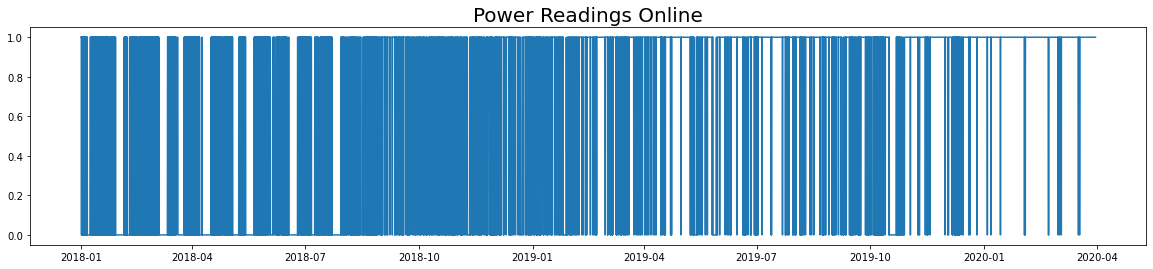

In [12]:
# ~20% of the target values (ActivePower) are null.
# I am worried that whole days worth of chunks are null.
# This could cause problems with reliability, splitting data, interpolation, etc.

power_readings_online = power.isnull()
power_readings_online.replace({True:0, False:1}, inplace=True)

plt.figure(figsize=(20,4))
plt.plot(power_readings_online[:-15])
plt.title('Power Readings Online', fontsize=20)
plt.show()


The above line graph is slightly misleading. A vertical blue line occurs when an on-off or off-on switch occurs.

The most concerning parts is where there is a visible horizontal blue line at y=0, notably in 2018. These are long periods of time where there are no readings for our target variable. 

In [13]:
# Find days for which ActivePower is almost always null.
# There are 99 days for which there are over 99 null readings for ActivePower

power_null_per_day = power.isnull().groupby(pd.Grouper(level='DateTime', freq='D')).sum()
power_null_per_day[power_null_per_day>99]


DateTime
2018-01-06 00:00:00+00:00    127
2018-01-07 00:00:00+00:00    144
2018-01-29 00:00:00+00:00    144
2018-01-30 00:00:00+00:00    144
2018-01-31 00:00:00+00:00    144
                            ... 
2019-10-18 00:00:00+00:00    144
2019-10-19 00:00:00+00:00    144
2019-10-20 00:00:00+00:00    144
2019-10-21 00:00:00+00:00    104
2019-10-27 00:00:00+00:00    142
Name: ActivePower, Length: 99, dtype: int64

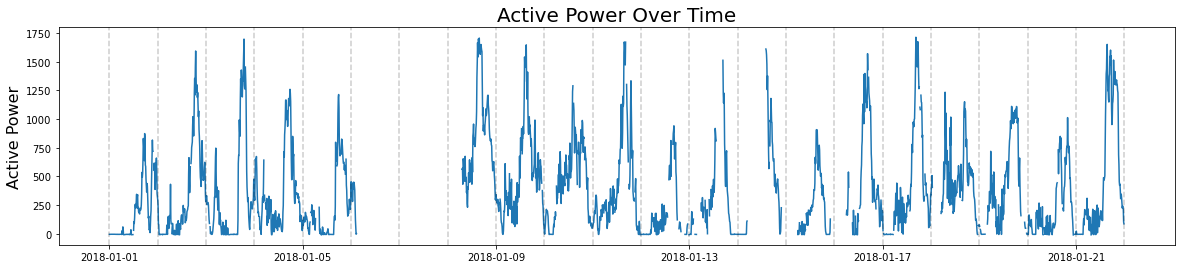

In [14]:
# Observations: 
# 1) Power exhibits daily periodic behavior.
# 2) Spikes usually occur mid-late day.
# 3) Periods of zero ActivePower often occur in the morning, but not always.
# 4) There exist large chunks of missing data (we already knew this)

plt.figure(figsize=(20,4))
plt.plot(power[:3024])    # Three weeks of data 3024 = 6*24*7*#
plt.title('Active Power Over Time', fontsize=20)
plt.ylabel('Active Power', fontsize=16)
for day in range(1, 23):
    plt.axvline(datetime(2018, 1, day), linestyle='--', color='k', alpha=0.2)

## Downsampling 
The task at hand is to predict 15 *days* of ActivePower. Since our time series enjoys a fine sampling frequency of 10 minutes, we might benefit from downsampling. Since there is a clear daily seasonal behavior, it would be most natural to downsample to a new frequency of 1 day.

I also believe this strategy will help mitigate some of the problems that our large amount of missing target data presents. It will be easier to interpolate when there are fewer consecutive null readings in the target variable.

### Aggregate by Mean
It would be best to aggregate the data by taking the mean over each day. This is because the approximation of total energy generated per day is preserved by the mean over time. To elaborate, Active Power $P$ is the rate of energy $E$. This means that we may approximate the energy generated per day by a Riemann sum
$$E_\approx = \sum_{i=1}^{N} P_i * 10$$
where the sum is over each 10-minute interval $i$ in the day, $N=6*24$ is the number of time intervals, and $P_i$ is the Active Power reading at that interval. This is equal to 
$$E_\approx = \Big(\sum_{i=1}^{N} P_i \Big) / N * 10N = \bar{P} * 10N$$
where $\bar{P}$ is the mean of the $P_i$. 


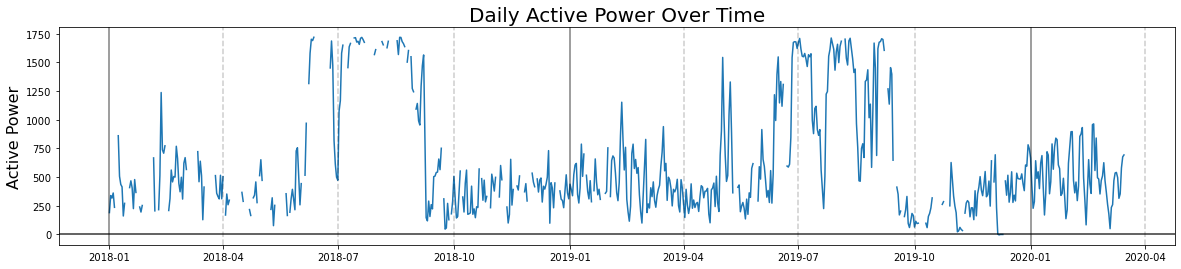

In [15]:
# Group target by day and aggregate by mean
power_daily = power.copy()
power_daily = power.groupby(pd.Grouper(level='DateTime', freq='D')).agg('mean')


# How many null readings per day defines an unreliable day? Max=6*24=144
null_threshold = 50

power_daily.rename('power_daily', inplace=True)
power_null_per_day.rename('power_null_per_day', inplace=True)
assert power_daily.size == power_null_per_day.size

# Set days with an unreliable number of readings to null
power_daily_info = pd.concat([power_daily, power_null_per_day], axis=1)
power_daily_info.loc[power_daily_info.power_null_per_day > null_threshold, 'power_daily'] = np.NaN

# Plotting
plt.figure(figsize=(20,4))
plt.plot(power_daily_info.power_daily[:-15])   
plt.title('Daily Active Power Over Time', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.5)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.5)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)




### Interpolation

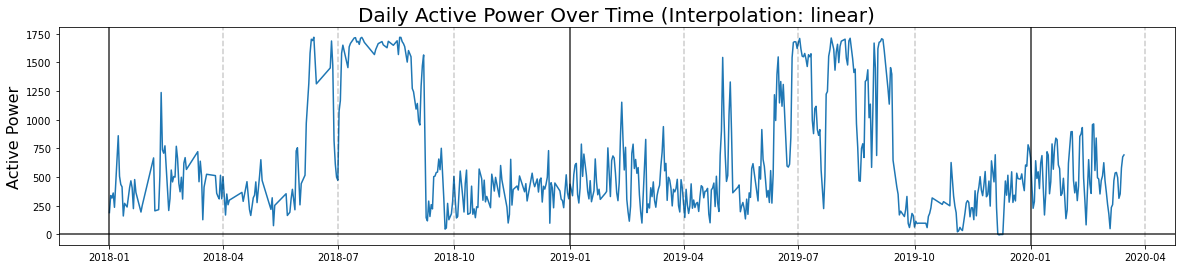

In [16]:
# Interpolate data
method = 'linear'
interpolated_daily = power_daily_info.power_daily.interpolate(method=method)

# Plotting
plt.figure(figsize=(20,4))
plt.plot(interpolated_daily[:-15])   
plt.title(f'Daily Active Power Over Time (Interpolation: {method})', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.8)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)

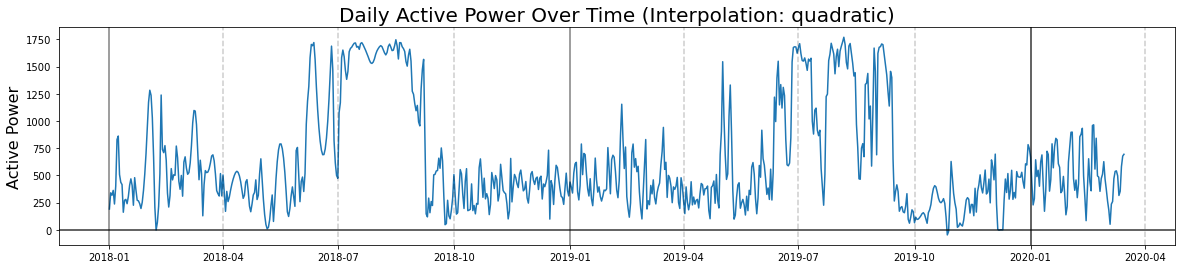

In [17]:
# Interpolate data
method = 'quadratic'
interpolated_daily = power_daily_info.power_daily.interpolate(method=method)

# Plotting
plt.figure(figsize=(20,4))
plt.plot(interpolated_daily[:-15])   
plt.title(f'Daily Active Power Over Time (Interpolation: {method})', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.5)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)

In [18]:
# Let's go with quadratic, it looks more "realistic".
power_daily = power_daily_info.power_daily.interpolate(method='quadratic')

## Train-Test Split

Let's set aside the final 15 days for our test data.

In [19]:
y = power_daily[-15:]
X = power_daily[:-15]

## Further Exploration

In [20]:
from statsmodels.tsa.stattools import adfuller

def adf_summary(X):
    '''Applies the Automated Dickey-Fuller test.
    Null-hypothesis: The time series is not stationary.'''
    adf = adfuller(X)
    print(f'ADF Statistic: {adf[0]}')
    print(f'p-value: {adf[1]}')
    print('Critical Values:')
    for key, value in adf[4].items():
        print(f'\t{key}: {value}')

    if adf[0] < adf[4]['5%']:
        print("Reject Null: Assume time series is stationary.")
    else:
        print("Fail to reject null: Time series may not be stationary.")

adf_summary(power_daily[:-15])


ADF Statistic: -3.10543177718303
p-value: 0.026153815385582414
Critical Values:
	1%: -3.438623132449471
	5%: -2.8651915799370014
	10%: -2.568714441670417
Reject Null: Assume time series is stationary.


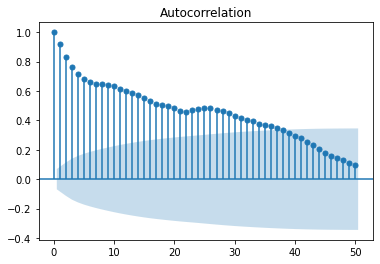

In [21]:
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decays
# The rate of decay is slow

acf_plot = plot_acf(X, lags=50)

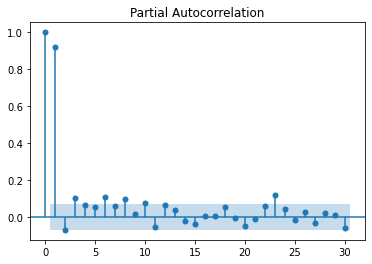

In [22]:
# Drops off quickly
# Significant lags: 1, 2(?), 3, 6, 8, 10(?), 23(?)

pacf_plot = plot_pacf(X)

## AutoRegressive (AR) Model

Let's try an AR model. This decision is based the rule of thumb that the ACF decays slowly while the PACF quickly drops for an AR time series. 

An $AR(p)$ model is a regression 
$$ X_t = \beta_0 + \beta_1 X_{t-1} + \dots + \beta_p X_{t-p} + \epsilon_t $$
where $X_i$ is the value of $X$ at time $i$, $\beta_j$ are the parameters, and $\epsilon_t$ is the error. In English, this says that the value of $X$ at any time $t$ is a constant plus some fixed linear combination of the values of $X$ at the previous $p$ time steps, within some level of error. 

The value $X_{t-i}$ is called the $i$-th lag of $X_t$. A rule of thumb says that the significant lags coincide with the values of the PACF curve that are large enough. Remember that the PACF plots the direct effect of $X_{t-i}$ on $X_t$. If the direct effect is small, then we may consider excluding it from our model. 

We can estimate the significant $\beta_i$ using an OLS method. We will tune the values of $\beta_i$ by a Walk Forward Validation. This simulates the process of updating a model as new information comes in.


In [23]:
from TimeSeriesHelpers import compare_AR_models

# Lag sets based on the PACF function.
lags0 = [1]
lags1 = [1, 2]
lags2 = [1, 2, 3]
lags3 = [1, 2, 3, 6]
lags4 = [1, 2, 3, 6, 23]
AR_lag_sets = [lags0, lags1, lags2, lags3, lags4]

compare_AR_models(AR_lag_sets, X, h=9)


Window Size: 45+9	Num Windows: 85

Test 0: AR(lags=[1])
RMSE Mean: 258.57	RMSE Variance: 28821.11

Test 1: AR(lags=[1, 2])
RMSE Mean: 255.69	RMSE Variance: 27966.54

Test 2: AR(lags=[1, 2, 3])
RMSE Mean: 255.81	RMSE Variance: 25887.62

Test 3: AR(lags=[1, 2, 3, 6])
RMSE Mean: 259.89	RMSE Variance: 25088.68

Test 4: AR(lags=[1, 2, 3, 6, 23])
ERR: CHECK LAG BOUNDS

Grand Mean RMSE: 257.492


In [24]:
compare_AR_models(AR_lag_sets, X, h=12)

Window Size: 60+12	Num Windows: 63

Test 0: AR(lags=[1])
RMSE Mean: 296.00	RMSE Variance: 43579.65

Test 1: AR(lags=[1, 2])
RMSE Mean: 292.89	RMSE Variance: 43225.15

Test 2: AR(lags=[1, 2, 3])
RMSE Mean: 288.85	RMSE Variance: 42663.41

Test 3: AR(lags=[1, 2, 3, 6])
RMSE Mean: 295.33	RMSE Variance: 49257.32

Test 4: AR(lags=[1, 2, 3, 6, 23])
ERR: CHECK LAG BOUNDS

Grand Mean RMSE: 293.266


In [25]:
compare_AR_models(AR_lag_sets, X, h=15)

Window Size: 75+15	Num Windows: 49

Test 0: AR(lags=[1])
RMSE Mean: 318.25	RMSE Variance: 41688.25

Test 1: AR(lags=[1, 2])
RMSE Mean: 318.59	RMSE Variance: 43071.42

Test 2: AR(lags=[1, 2, 3])
RMSE Mean: 315.51	RMSE Variance: 42818.29

Test 3: AR(lags=[1, 2, 3, 6])
RMSE Mean: 316.43	RMSE Variance: 47290.39

Test 4: AR(lags=[1, 2, 3, 6, 23])
RMSE Mean: 324.79	RMSE Variance: 55636.62


Grand Mean RMSE: 318.716


In [26]:
compare_AR_models(AR_lag_sets, X, h=18)

Window Size: 90+18	Num Windows: 40

Test 0: AR(lags=[1])
RMSE Mean: 289.85	RMSE Variance: 26576.52

Test 1: AR(lags=[1, 2])
RMSE Mean: 294.45	RMSE Variance: 26543.98

Test 2: AR(lags=[1, 2, 3])
RMSE Mean: 296.08	RMSE Variance: 26533.69

Test 3: AR(lags=[1, 2, 3, 6])
RMSE Mean: 294.53	RMSE Variance: 26237.86

Test 4: AR(lags=[1, 2, 3, 6, 23])
RMSE Mean: 296.72	RMSE Variance: 29951.93


Grand Mean RMSE: 294.326


In [27]:
compare_AR_models(AR_lag_sets, X, h=27)

Window Size: 135+27	Num Windows: 25

Test 0: AR(lags=[1])
RMSE Mean: 362.12	RMSE Variance: 62483.02

Test 1: AR(lags=[1, 2])
RMSE Mean: 367.43	RMSE Variance: 60996.55

Test 2: AR(lags=[1, 2, 3])
RMSE Mean: 369.77	RMSE Variance: 61881.73

Test 3: AR(lags=[1, 2, 3, 6])
RMSE Mean: 365.73	RMSE Variance: 61155.65

Test 4: AR(lags=[1, 2, 3, 6, 23])
RMSE Mean: 357.97	RMSE Variance: 61329.20


Grand Mean RMSE: 364.607


The lags from Test 0 will probably perform the best. Test 0 has relatively low RMSE Mean scores while also maintaining a relatively low RMSE Variance scores. 

Let's choose the AR(lags0) model which has been optimized on the forecast horizon size `h=9` since the models generally did the best for this value of `h`. So our rolling window should have a size of `45=h*5`

## AutoRegressive + Moving Average (ARMA) Model

Let's see if we get a better model if we include a Moving Average (MA) part. An ARMA model is simply a sum of an AR and an MA model. A Moving Average model $MA(q)$ is a regression 
$$
X_t = \mu + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$
where $\epsilon_i$ is the error at time $t$ and the $\theta_i$ are the parameters. Intuitively, the model is modeling behavior which self-corrects to the mean $\mu$. 

An $ARMA(p,q)$ model is of the form $AR(p) + MA(q)$.

In [28]:
from TimeSeriesHelpers import compare_ARMA_models
import warnings

warnings.filterwarnings("ignore")   # Might be convergence issues with some (p,q) values

MA_lag_sets = [1, 2, 3]

compare_ARMA_models(AR_lag_sets, MA_lag_sets, X, h=9)

Window Size: 45+9	Num Windows: 85

Test 1: ARMA(p=[1], q=1)
RMSE Mean: 260.83	RMSE Variance: 29795.28

Test 2: ARMA(p=[1], q=2)
RMSE Mean: 267.79	RMSE Variance: 29222.09

Test 3: ARMA(p=[1], q=3)
RMSE Mean: 269.92	RMSE Variance: 27265.39

Test 4: ARMA(p=[1, 2], q=1)
RMSE Mean: 253.43	RMSE Variance: 27525.82

Test 5: ARMA(p=[1, 2], q=2)
RMSE Mean: 263.29	RMSE Variance: 27280.53

Test 6: ARMA(p=[1, 2], q=3)
RMSE Mean: 268.55	RMSE Variance: 25401.98

Test 7: ARMA(p=[1, 2, 3], q=1)
RMSE Mean: 261.96	RMSE Variance: 27409.65

Test 8: ARMA(p=[1, 2, 3], q=2)
RMSE Mean: 269.54	RMSE Variance: 27910.08

Test 9: ARMA(p=[1, 2, 3], q=3)
RMSE Mean: 271.74	RMSE Variance: 27751.09

Test 10: ARMA(p=[1, 2, 3, 6], q=1)
RMSE Mean: 268.95	RMSE Variance: 27007.22

Test 11: ARMA(p=[1, 2, 3, 6], q=2)
RMSE Mean: 279.75	RMSE Variance: 29872.88

Test 12: ARMA(p=[1, 2, 3, 6], q=3)
RMSE Mean: 285.19	RMSE Variance: 29442.12

Test 13: ARMA(p=[1, 2, 3, 6, 23], q=1)
RMSE Mean: 603.67	RMSE Variance: 540891.37

Test 14: 

Choose $p=2$ and $q=1$ based on tests. 

## LSTM

A Long Short-Term Memory Recurrent Neural Network (LSTM) is a Recurrent neural network (RNN) that is designed to address the vanishing and exploding gradient problems of conventional RNNs. The $t+1$ th hidden state is defined like $$H_{t+1} = A(H_t, x_t)$$
where $x_t$ is the $t$ th point in the sequence and $A$ is some activation. 
<p align="center">
    <img src="Unrolled_RNN.png" width="600" />
</p>
This type of network suffers from short-term memory loss. This means that information passed through the system earlier in the sequence will contribute less to the output. If $t$ has a large range, then the activation $A$ is called many times recursively, which means the gradient will contain many products of $A$. An LSTM defines $A$ in a clever way so that the gradients are less likely to explode or vanish. 
<p align="center">
    <img src="LSTM_cell.png" width="600" />
</p>
As new information $x_t$ is inputted into (the bottom of) the system, it and the previous hidden state are passed through multiple gates which regulate the cell state (at the top). This allows for the inherent short-term memory of the RNN to be prolonged, as the system can choose to remember or forget specific bits of the sequence data along the way.


http://colah.github.io/posts/2015-08-Understanding-LSTMs/
https://arxiv.org/abs/1402.1128

In [47]:
import torch
import torch.nn as nn

In [48]:
# Prepare data for neural network training
def training_data_from_sequence(seq:torch.tensor, window:int) -> torch.tensor:
    "Splits a sequence into tensors ready for rolling window training/validation."
    assert len(seq.shape) == 1, 'Sequence must be a 1D tensor'
    n = seq.shape[0]
    assert window < n, 'Window size must be smaller than time series.'
    num_windows = n - window
    X, y = torch.empty(num_windows, window), torch.empty(num_windows)
    for i in range(num_windows):
        X[i] = seq[i:i+window]
        y[i] = seq[i+window]
    return X, y

In [49]:
from sklearn.preprocessing import MinMaxScaler

# Scale train and test data for the neural network
X_scaled = np.array(X.values)
y_scaled = np.array(y.values)
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(X_scaled, axis=1))
X_scaled = scaler.transform(np.expand_dims(X_scaled, axis=1))
y_scaled = scaler.transform(np.expand_dims(y_scaled, axis=1))
X_scaled = torch.from_numpy(X_scaled).view(-1)
y_scaled = torch.from_numpy(y_scaled).view(-1)

# Split train into train/val windows
window = 45
Xs, vals = training_data_from_sequence(seq=X_scaled, window=window)

print(f"Xs.shape: {Xs.shape}")
print(f"vals.shape: {vals.shape}")


Xs.shape: torch.Size([760, 45])
vals.shape: torch.Size([760])


In [50]:
class LSTMForecaster(nn.Module):

    def __init__(self, num_features, hidden_dim, seq_length, num_layers=2):
        super(LSTMForecaster, self).__init__()

        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        #self.batch_size = batch_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=num_features, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers,
                            dropout=0.5,
                            batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim,
                            out_features=1)

    #def reset_hidden_state(self):
    #    self.hidden = (
    #        torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
    #        torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
    #    )

    def forward(self, input):
        batch_size = len(input)
        out, _ = self.lstm(
            input.view(batch_size, self.seq_length, self.num_features)
        )
        # out: [batch_size, num_hidden_states, hidden_size]
        out = self.fc(
            out.view(batch_size, self.seq_length, self.hidden_dim)[:,-1,:]
        )
        return out

In [51]:
def train_ANN(model, X_train, y_train, X_test=None, y_test=None, learn_rate=1e-3, num_epochs=60, print_every=10):

    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    train_hist = np.zeros(num_epochs)

    for i in range(num_epochs):
        #model.reset_hidden_state()
        y_pred = model(X_train).view(-1)
        loss = loss_fn(y_pred.float().view(-1), y_train)
        train_hist[i] = loss.item()
        test_hist = np.zeros(num_epochs)

        if X_test is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.view(-1), y_test)
            test_hist[i] = test_loss.item()
            if (i+1) % print_every == 0:
                print(f"Epoch {i+1} train loss: {loss.item():.5f}\ttest loss: {test_loss.item():.5f}")
        elif (i+1) % print_every == 0:
            print(f"Epoch {i} train loss: {loss.item():.5f}")


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    final_preds = y_test_pred
    
    # model.eval turns off dropout layers
    return model.eval(), final_preds, train_hist, test_hist
        

In [59]:
hidden_dim = 64
test_size = 15
num_epochs = 50


# Initialize model with hidden_dim=64
model_lstm64 = LSTMForecaster(num_features=1, 
                              hidden_dim=hidden_dim, 
                              seq_length=Xs.shape[1])

# Train model
model_lstm64, y_hat_scaled, _, _ = train_ANN(model=model_lstm64, 
                                            X_train=Xs[:-test_size,:], 
                                            y_train=vals[:-test_size], 
                                            X_test=Xs[-test_size:,:], 
                                            y_test=vals[-test_size:],
                                            num_epochs=num_epochs)


y_hat_scaled = scaler.inverse_transform(y_hat_scaled)
y_hat_lstm64 = y.copy()
for i in range(len(y_hat_scaled)):
    y_hat_lstm64.iloc[i] = y_hat_scaled[i,:]


Epoch 10 train loss: 0.08303	test loss: 0.00975
Epoch 20 train loss: 0.06302	test loss: 0.04664
Epoch 30 train loss: 0.05350	test loss: 0.01463
Epoch 40 train loss: 0.03568	test loss: 0.02831
Epoch 50 train loss: 0.03122	test loss: 0.01249


In [60]:
hidden_dim = 128

# Initialize model with hidden_dim=128
model_lstm128 = LSTMForecaster(num_features=1, 
                               hidden_dim=hidden_dim, 
                               seq_length=Xs.shape[1])

# Train model
model_lstm128, y_hat_scaled, _, _ = train_ANN(model=model_lstm128, 
                                              X_train=Xs[:-test_size,:], 
                                              y_train=vals[:-test_size], 
                                              X_test=Xs[-test_size:,:], 
                                              y_test=vals[-test_size:],
                                              num_epochs=num_epochs)


y_hat_scaled = scaler.inverse_transform(y_hat_scaled)
y_hat_lstm128 = y.copy()
for i in range(len(y_hat_scaled)):
    y_hat_lstm128.iloc[i] = y_hat_scaled[i,:]

Epoch 10 train loss: 0.07120	test loss: 0.05856
Epoch 20 train loss: 0.05047	test loss: 0.01885
Epoch 30 train loss: 0.03052	test loss: 0.01189
Epoch 40 train loss: 0.02649	test loss: 0.01230
Epoch 50 train loss: 0.02457	test loss: 0.01290


In [61]:
hidden_dim = 256

# Initialize model with hidden_dim=256
model_lstm256 = LSTMForecaster(num_features=1, 
                               hidden_dim=hidden_dim, 
                               seq_length=Xs.shape[1])

# Train model
model_lstm256, y_hat_scaled, _, _ = train_ANN(model=model_lstm256, 
                                              X_train=Xs[:-test_size,:], 
                                              y_train=vals[:-test_size], 
                                              X_test=Xs[-test_size:,:], 
                                              y_test=vals[-test_size:],
                                              num_epochs=num_epochs)


y_hat_scaled = scaler.inverse_transform(y_hat_scaled)
y_hat_lstm256 = y.copy()
for i in range(len(y_hat_scaled)):
    y_hat_lstm256.iloc[i] = y_hat_scaled[i,:]

Epoch 10 train loss: 0.06862	test loss: 0.01207
Epoch 20 train loss: 0.05416	test loss: 0.05267
Epoch 30 train loss: 0.02809	test loss: 0.01117
Epoch 40 train loss: 0.02460	test loss: 0.01172
Epoch 50 train loss: 0.02270	test loss: 0.01261


## Testing

Let's compare our models on the last 15 days of data. Each day we will train our models, then make predictions for the next day, and finally update our training data to include the true value for the next day. 

### Baselines

Lets made two baseline predictions. The first baseline will predict the next observation to be equal to the previous observation. The second baseline will predict the next `h` observations to be equal to the previous `h` predictions. 

In [62]:
from TimeSeriesHelpers import LastBaseline
from TimeSeriesHelpers import RepeatBaseline

model_last = LastBaseline()
model_repeat = RepeatBaseline()

model_last.fit(X)
model_repeat.fit(X)

y_hat_last = model_last.forecast(y)
y_hat_repeat = model_repeat.forecast(y)

### Train Models

To forecast multiple days in advance, we predict one day at a time, feed this prediction back into the training data, and retrain the model on the updated training data.

In [63]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

X_updated_AR = X.copy()
X_updated_ARMA = X.copy()
y_hat_AR = y.copy()
y_hat_ARMA = y.copy()

lags_AR = lags0
p_ARMA = 2
q_ARMA = 1

window = 45

for i in range(15):
    # Train models
    model_fit_AR = AutoReg(endog=X_updated_AR.iloc[:-window], lags=lags_AR, old_names=False).fit()
    model_fit_ARMA = ARIMA(endog=X_updated_ARMA.iloc[:-window], order=(p_ARMA, 0, q_ARMA), 
                           enforce_stationarity=False).fit()

    # Make predictions
    pred_AR = model_fit_AR.forecast(1)
    pred_ARMA = model_fit_ARMA.forecast(1)
    y_hat_AR.iloc[i] = pred_AR
    y_hat_ARMA.iloc[i] = pred_ARMA
    # Update training data with prediction
    X_updated_AR = X_updated_AR.append(y_hat_AR[i:i+1])
    X_updated_ARMA = X_updated_ARMA.append(y_hat_ARMA[i:i+1])

In [64]:
y_hat_lstm128ARMA = (y_hat_ARMA + y_hat_lstm128) / 2

### Results

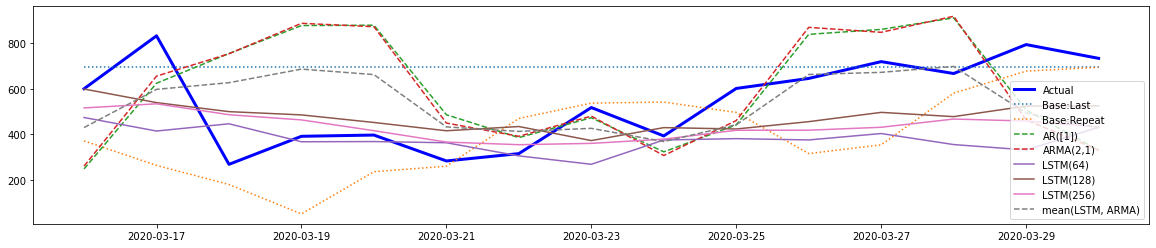

In [65]:
plt.figure(figsize=(20,4))
plt.plot(y, label='Actual', linewidth=3.0, color='blue')
plt.plot(y_hat_last, label='Base:Last', linestyle='dotted')
plt.plot(y_hat_repeat, label='Base:Repeat', linestyle='dotted')
plt.plot(y_hat_AR, label=f'AR({lags_AR})', linestyle='dashed')
plt.plot(y_hat_ARMA, label=f'ARMA({p_ARMA},{q_ARMA})', linestyle='dashed')
plt.plot(y_hat_lstm64, label=f'LSTM(64)')
plt.plot(y_hat_lstm128, label=f'LSTM(128)')
plt.plot(y_hat_lstm256, label=f'LSTM(256)')
plt.plot(y_hat_lstm128ARMA, label=f'mean(LSTM, ARMA)', linestyle='dashed')
plt.legend(loc='lower right')
plt.show()

In [66]:
from math import sqrt
from sklearn.metrics import mean_squared_error

y_hat_last.rename('LastBaseline', inplace=True)
y_hat_repeat.rename('RepeatBaseline', inplace=True)
y_hat_AR.rename(f'AR({lags_AR})', inplace=True)
y_hat_ARMA.rename(f'ARMA({p_ARMA}, {q_ARMA})', inplace=True)
y_hat_lstm64.rename(f'LSTM(64)', inplace=True)
y_hat_lstm128.rename(f'LSTM(128)', inplace=True)
y_hat_lstm256.rename(f'LSTM(256)', inplace=True)
y_hat_lstm128ARMA.rename(f'mean(LSTM(128),ARMA)', inplace=True)

y_hats = [y_hat_last, y_hat_repeat, y_hat_AR, y_hat_ARMA, y_hat_lstm64, y_hat_lstm128, y_hat_lstm256, y_hat_lstm128ARMA]

for y_hat in y_hats:
    rmse = sqrt(mean_squared_error(y, y_hat))
    print(f"Predictions: {y_hat.name}\t\tRMSE: {rmse:.3f}")

Predictions: LastBaseline		RMSE: 237.559
Predictions: RepeatBaseline		RMSE: 237.683
Predictions: AR([1])		RMSE: 295.769
Predictions: ARMA(2, 1)		RMSE: 296.223
Predictions: LSTM(64)		RMSE: 247.010
Predictions: LSTM(128)		RMSE: 177.822
Predictions: LSTM(256)		RMSE: 198.895
Predictions: mean(LSTM(128),ARMA)		RMSE: 203.728
